## Rainfall Prediction
- For this project I will use a dataset which recorded the weather of 20 major cities in USA from 2024-2025 to predict rainfall! It will use data from the day before to determine whether or not it will rain. We will use multiple classifiers such as a Support Vector Classifier, Extreme Gradient Boost Classifier, and a Logistic Regressor, measuring their performances to see which is best for predicting rainfall.

In [63]:
%pip install pydantic

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [33]:
# Load the dataset
df = pd.read_csv('usa_rain_prediction_dataset_2024_2025.csv')
df.head()

,Date,Location,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow
0,2024-01-01,New York,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0
1,2024-01-02,New York,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0
2,2024-01-03,New York,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1
3,2024-01-04,New York,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0
4,2024-01-05,New York,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0


In [23]:
# Examine the size of the dataset
df.shape

(73100, 9)

In [24]:
# See the column types we are working with in the dataset and check for any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           73100 non-null  object 
 1   Location       73100 non-null  object 
 2   Temperature    73100 non-null  float64
 3   Humidity       73100 non-null  float64
 4   Wind Speed     73100 non-null  float64
 5   Precipitation  73100 non-null  float64
 6   Cloud Cover    73100 non-null  float64
 7   Pressure       73100 non-null  float64
 8   Rain Tomorrow  73100 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.0+ MB


In [25]:
# There seems to be null values which is good, so now we will look at the distribution of the data
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,65.182270,59.875041,15.017946,0.390635,54.942807,1005.176013,0.220410
std,20.205793,23.066115,8.668729,0.474833,25.982487,20.203889,0.414526
min,30.000766,20.000272,0.000712,0.000000,10.000856,970.000919,0.000000
25%,47.678968,39.800732,7.485182,0.000000,32.318668,987.697646,0.000000
50%,65.294949,59.887840,15.102495,0.196909,55.011121,1005.284188,0.000000
75%,82.636570,79.835990,22.551794,0.673177,77.412469,1022.727410,0.000000
max,99.997393,99.999025,29.999017,3.078090,99.998957,1039.999765,1.000000


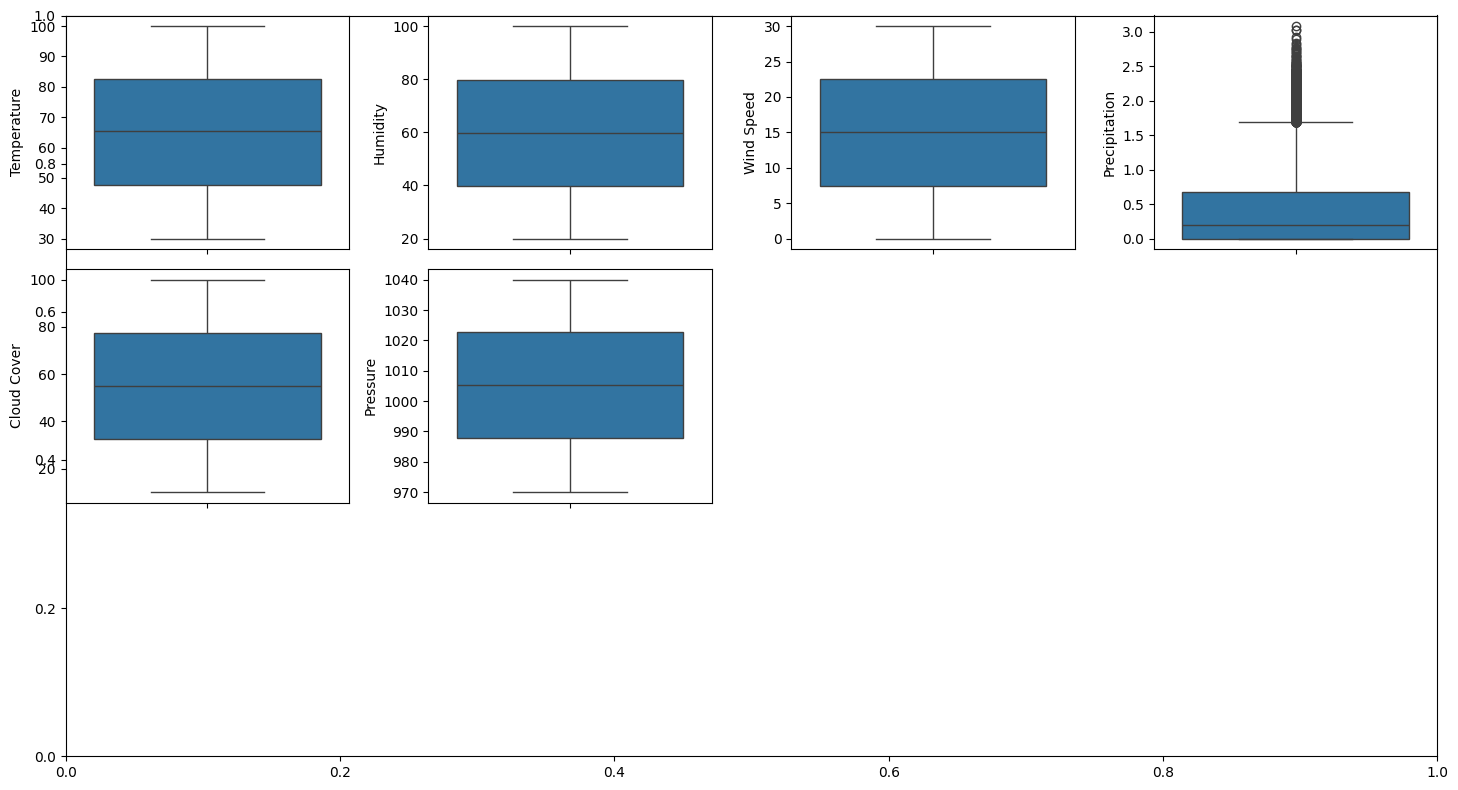

In [26]:
# Better visualize the distributions through boxplots
features = list(df.select_dtypes(include = np.number).columns)
# Remove Rain Tomorrow since it is just 1 and 0
features.remove('Rain Tomorrow')
plt.subplots(figsize=(15,8))

for i, col in enumerate(features):
  plt.subplot(3,4, i + 1)
  sb.boxplot(df[col])
plt.tight_layout()
plt.show()

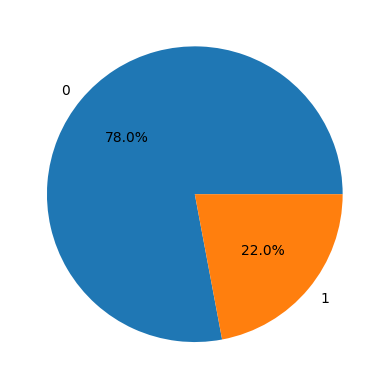

In [27]:
# Lets also look at the distribution of it raining the next day to not raining within this dataset
# 0 represents no rain, 1 represents rain
plt.pie(df['Rain Tomorrow'].value_counts().values,
        labels = df['Rain Tomorrow'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [28]:
# We can also see the average numbers for the weather conditions when it rains the next day to get a better idea of what to look for
df.groupby('Rain Tomorrow').mean(numeric_only=True)

,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure
Rain Tomorrow,,,,,,
0,65.220869,54.213123,15.071944,0.266971,54.989568,1005.199426
1,65.045748,79.901198,14.826955,0.828034,54.777412,1005.093203


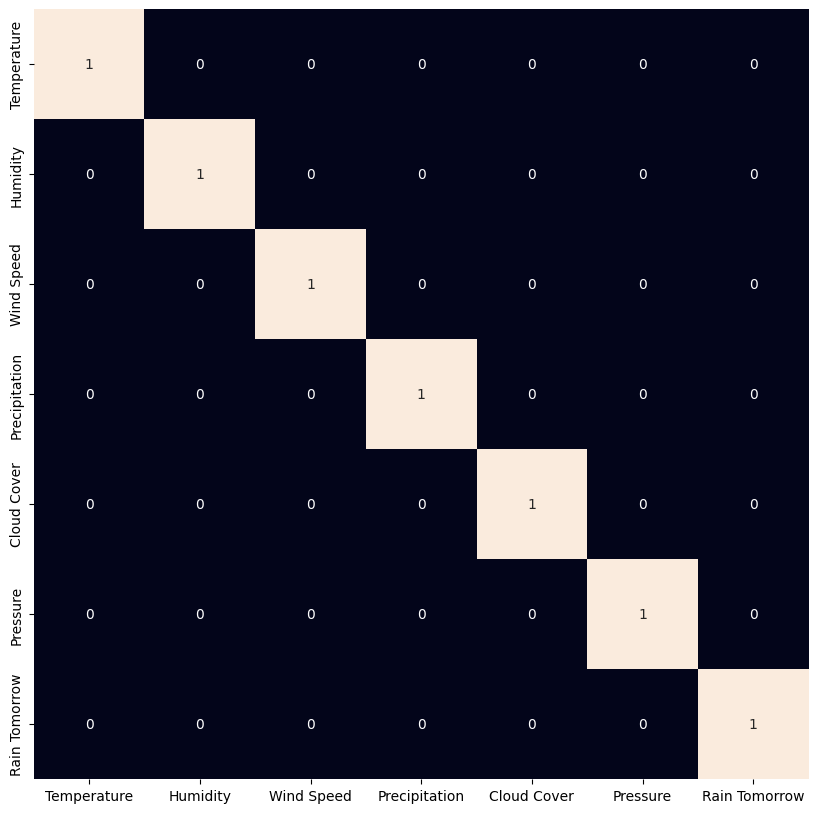

In [36]:
# Check for high correlation between numeric features which are repititive/not helpful for the model
num_features = df.drop(['Date','Location'], axis=1)
plt.figure(figsize=(10,10))
sb.heatmap(num_features.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

In [47]:
# Now lets train the model by first starting to train test split the features and target
features = df.drop(['Date','Location', 'Rain Tomorrow'], axis=1)
target = df['Rain Tomorrow']

X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, stratify=target, random_state=2)


In [48]:
# Normalize the features for faster training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
# Evaluate the perfomance of the different models on our training and testing data
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for i in range(3):
  models[i].fit(X_train, y_train)

  print(f'{models[i]} : ')

  train_preds = models[i].predict_proba(X_train) 
  print('Training Accuracy : ', metrics.roc_auc_score(y_train, train_preds[:,1]))

  val_preds = models[i].predict_proba(X_val) 
  print('Validation Accuracy : ', metrics.roc_auc_score(y_val, val_preds[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.9488647507696266
Validation Accuracy :  0.9508598871005389

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.9999963511953757

SVC(probability=True) : 
Training Accuracy :  0.9994284598227

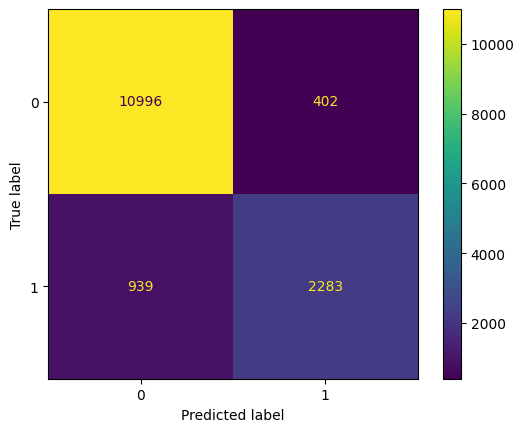

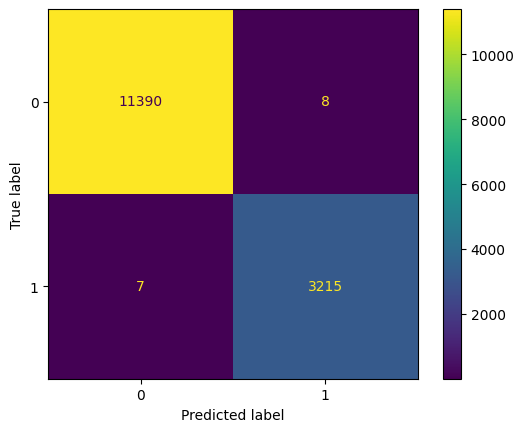

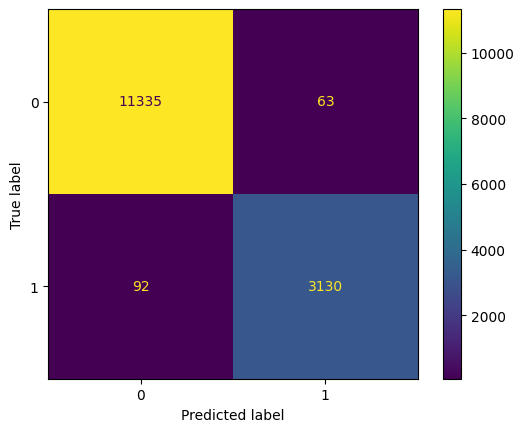

In [54]:
# Visualize and examine the performance of the models further through the use of confusion matrices
import matplotlib.pyplot as plt 
from sklearn.metrics import ConfusionMatrixDisplay

# Logistic Regression
ConfusionMatrixDisplay.from_estimator(models[0], X_val, y_val)
plt.show()

# XGB Classifier
ConfusionMatrixDisplay.from_estimator(models[1], X_val, y_val)
plt.show()

# Support Vector Classifier
ConfusionMatrixDisplay.from_estimator(models[2], X_val, y_val)
plt.show()

In [57]:
# Logistic Regression
print("Logistic Regression:")
print(metrics.classification_report(y_val, models[0].predict(X_val)))

# XGB Classifier
print("XGB Classifier:")
print(metrics.classification_report(y_val, models[1].predict(X_val)))

# Support Vector Classifier
print("Support Vector Classifier:")
print(metrics.classification_report(y_val, models[2].predict(X_val)))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11398
           1       0.85      0.71      0.77      3222

    accuracy                           0.91     14620
   macro avg       0.89      0.84      0.86     14620
weighted avg       0.91      0.91      0.91     14620

XGB Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11398
           1       1.00      1.00      1.00      3222

    accuracy                           1.00     14620
   macro avg       1.00      1.00      1.00     14620
weighted avg       1.00      1.00      1.00     14620

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11398
           1       0.98      0.97      0.98      3222

    accuracy                           0.99     14620
   macro avg       0.99      0.98      0.98     14620
weighted a

## Conclusion
- Our dataset was pretty clean and nice to work with, we did not have too many highly correlated features that we need to remove nor any null rows that needed to be deleted. Because of this we did not need to do much data cleaning and were able to just input the data into our models for training and testing. After training and testing we see that both classifiers performed close to perfect on the data with the XGB Classifier being 100% accurate during training. When testing/validating we see there is minimal differences between the training accuracy and testing accuracy proving our models are performing well. The regressor still performed well, but did not do as well as the two classifiers. It mislabeled rain tomorrow when it did not rain the next day 402 times and said no rain tomorrow when it did rain the next day 939 times. In summary all of our models performed well enough, and this performance can be attributed to the amount of data it was fed as well as the good quality of the data.

In [61]:
# Code to execute the Support Vector Classifier to make new predictions
def rainfall_prediction_SVC(test_input):
    test_scaled = scaler.transform([test_input])
    prediction = models[2].predict(test_scaled)[0]
    if (prediction):
        return True
    return False

rainfall_prediction_SVC([80.94,64.74,14.18,0.91,77.36,980.79])

True